<a href="https://www.kaggle.com/code/fummicc1/fummicc1-cassava?scriptVersionId=115383373" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [27]:
# !pip install --upgrade torch torchvision

## Data

In [28]:
import torch
import torch.nn as nn
import pandas as pd
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, List, Tuple
from tqdm import tqdm
import pandas as pd

In [29]:
class Config:
    # base_input_path = "/kaggle/input/cassava-leaf-disease-classification"
    base_input_path = "./"
    batch_size = 64
    num_workers = 4
    n_epochs = 30
    lr = 1e-4
    
    def __init__(self):
        pass
    
config = Config()

def convert_num2label(num: int) -> str:
    return {
        "0": "Cassava Bacterial Blight (CBB)",
        "1": "Cassava Brown Streak Disease (CBSD)",
        "2": "Cassava Green Mottle (CGM)",
        "3": "Cassava Mosaic Disease (CMD)",
        "4": "Healthy",
    }[num]


def class2dict(f) -> Dict:
    ans = dict()
    for name in dir(f):
        if name.startswith("__"):
            continue
        if not _is_primitive(getattr(f, name)):
            ans[name] = class2dict(getattr(f, name))
        else:
            ans[name] = getattr(f, name)
    return ans


def _is_primitive(value) -> bool:
    primitive = (int, str, bool, float, List, Dict)
    return type(value) in primitive

<AxesSubplot: >

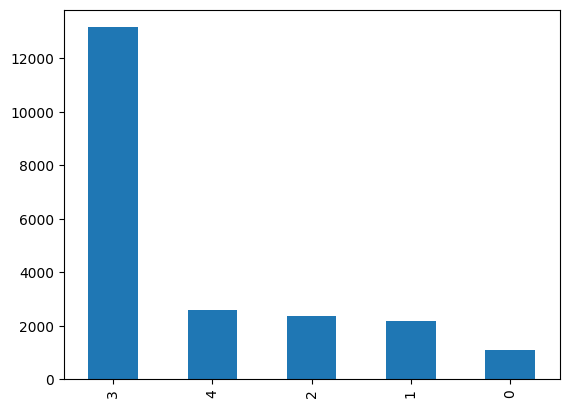

In [30]:
train_path = os.path.join(config.base_input_path, "train.csv")
train_img_dir_path = os.path.join(config.base_input_path, "train_images")
train_df = pd.read_csv(train_path)
train_df.label.value_counts().plot(kind="bar")

In [31]:
from typing import Optional

class CassavaDataset(Dataset):
    def __init__(self, annotation_path: Optional[str], img_dir_path: str, img_transforms: transforms.Compose):
        self.has_label = annotation_path is not None
        if annotation_path:
            self.annotation_path = annotation_path
            self.annotation_data = pd.read_csv(annotation_path)
        else:
            self.annotation_path = None
            self.annotation_data = pd.DataFrame()
            self.annotation_data["image_id"] = list(os.listdir(img_dir_path))
        self.img_dir_path = img_dir_path
        self.img_transforms = img_transforms
        
    def __len__(self) -> int:
        return len(self.annotation_data)
    
    def __getitem__(self, index: int):
        data = self.annotation_data.iloc[index, :]
        image_id = data["image_id"]
        if self.has_label:
            label = data["label"]
        image_path = os.path.join(self.img_dir_path, image_id)        
        img = Image.open(image_path).convert("RGB")
        if self.img_transforms:
            img = self.img_transforms(img)
        if self.has_label:
            label = torch.nn.functional.one_hot(torch.tensor([label]), num_classes=5)
            label = torch.squeeze(label, dim=0).float()
        return img, image_id, label if self.has_label else None

## Network

In [32]:
from torchvision.models import resnet18


class CassavaNetwork(nn.Module):
    def __init__(self, input_dim: int = 3, output_dim: int = 5):
        super().__init__()
        weight_path = "/kaggle/input/resnet18pretrained/resnet18-f37072fd.pth"
        if os.path.exists(weight_path):
            self.base_model = resnet18()
            self.base_model.load_state_dict(
                torch.load(weight_path)
            )
        else:
            self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(
            input_dim,
            64,
            kernel_size=(7, 7),
            stride=(2, 2), 
            padding=(3, 3), 
            bias=False
        )
        self.base_model.fc = nn.Linear(in_features=512, out_features=output_dim, bias=True)
    
    def forward(self, img: torch.Tensor) -> torch.Tensor:
        return self.base_model(img)
    

model = CassavaNetwork()

/workspace/kaggle-notebooks/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/kaggle-notebooks/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Trainer

In [33]:
import numpy as np
from typing import Optional
from torch.cuda.amp.grad_scaler import GradScaler
from torch.cuda.amp.autocast_mode import autocast
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch

import sys
import os


class TrainerOutput:
    loss: float

    def __init__(self, loss: float):
        self.loss = loss

    @property
    def score(self) -> float:
        return self.loss


class Trainer:
    model: nn.Module
    optimizer: optim.Optimizer
    lr_scheduler: optim.lr_scheduler._LRScheduler
    loss_function: nn.CrossEntropyLoss
    dataloader: DataLoader
    scaler: Optional[GradScaler]

    def __init__(
        self,
        model: nn.Module,
        optimizer: optim.Optimizer,
        lr_scheduler: optim.lr_scheduler._LRScheduler,
        loss_function: nn.CrossEntropyLoss,
        dataloader: DataLoader,
        scaler: Optional[GradScaler] = None,
    ):
        self.model = model
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_function = loss_function
        self.dataloader = dataloader
        self.scaler = scaler

    def advance(self, verbose: bool = False) -> TrainerOutput:
        scaler = None
        if self.scaler:
            scaler = self.scaler
        self.model = self.model.train()
        GPU_DEVICE = torch.device("cuda")
        epoch_loss = 0
        with autocast(enabled=True):
            with torch.enable_grad():
                for batch in tqdm(self.dataloader):
                    if len(batch) == 3:
                        imgs, ids, labels = batch
                    elif len(batch) == 2:
                        imgs, labels = batch
                    else:
                        continue
                    self.optimizer.zero_grad()
                    imgs = imgs.to(GPU_DEVICE)
                    labels = labels.to(GPU_DEVICE)
                    out: torch.Tensor = self.model(imgs)
                    out = out.float()
                    if verbose:
                        print("out-shape", out.shape)
                        print("out", out)                        
                    if verbose:
                        print("labels", labels)
                    loss = self.loss_function(out, labels)
                    if verbose:
                        print("loss", loss)
                    if scaler is not None:
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()
                    epoch_loss += loss.item()
                    if scaler is not None:
                        scaler.step(self.optimizer)
                        scaler.update()
                    else:
                        self.optimizer.step()
                self.lr_scheduler.step()
        loss = epoch_loss / (len(self.dataloader))
        return TrainerOutput(loss=loss)

## Classifier

In [34]:
from typing import Callable, Dict, List, Tuple, Union, Optional
from typing_extensions import Self
import numpy as np
from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import sys
import os


class ClassifierOutput:
    move_to_full_nn_img_ids: List[str]
    count: int
    acc: float
    loss: float
    df: pd.DataFrame

    def __init__(
        self,
        count: int,
        acc: float,
        loss: float,
        df: pd.DataFrame = pd.DataFrame()
    ):
        self.count = count        
        self.acc = acc
        self.loss = loss
        self.df = df

    @property
    def score(self) -> float:
        return self.acc


class ClassifierTrainInput:
    def __init__(self):
        pass

class ClassifierTestInput:
    def __init__(self):
        pass

class Classifier:

    model: nn.Module
    activate_function: nn.Softmax
    loss_function: Optional[nn.CrossEntropyLoss]
    c_high: float
    c_low: float
    dataloader: DataLoader
    phase: str
    phase_input: Union[ClassifierTrainInput, ClassifierTestInput]
    on_classify: Optional[Callable]

    def __init__(
        self,
        model: nn.Module,
        activate_function: nn.Softmax,
        dataloader: DataLoader,
        phase: str,
        phase_input: Union[ClassifierTrainInput, ClassifierTestInput],
        loss_function: Optional[nn.CrossEntropyLoss] = None,
        on_classify: Optional[Callable] = None,
    ):
        self.model = model
        self.activate_function = activate_function
        self.loss_function = loss_function
        self.dataloader = dataloader
        self.phase = phase
        self.phase_input = phase_input
        self.on_classify = on_classify

    def infer(
        self, verbose: bool = False, handle_all: bool = False, calc_acc: bool = True
    ) -> ClassifierOutput:
        net = self.model
        loader = self.dataloader
        loss_function = self.loss_function
        count = 0
        correct = 0        
        GPU_DEVICE = torch.device("cuda")
        called = False
        net = net.eval()
        epoch_loss = 0
        label_df = pd.DataFrame()
        with torch.no_grad():
            for batch in tqdm(loader):
                if len(batch) == 3:
                    imgs, ids, labels = batch
                elif len(batch) == 2:
                    imgs, ids = batch
                    labels = None
                else:
                    continue
                imgs = imgs.to(GPU_DEVICE)
                if labels is not None:
                    labels = labels.to(GPU_DEVICE)                
                outputs = net(imgs)
                if loss_function and labels is not None:
                    loss = loss_function(outputs, labels)
                    epoch_loss += loss.item()
                outputs = self.activate_function(outputs)
                if verbose:
                    print("output", outputs[:10])
                _, pred_indexes = torch.max(outputs, dim=1)
                pred_indexes: Tensor = pred_indexes
                if verbose:
                    print(f"{self.phase}_predicted_indexes", pred_indexes)
                    print(f"{self.phase}_labels", labels)
                if not called and self.on_classify is not None:
                    if not handle_all:
                        called = True
                    self.on_classify(imgs, pred_indexes)
                
                pred_indexes = torch.tensor(list(map(lambda nums: (nums==1).nonzero().item(), pred_indexes))).to(GPU_DEVICE)
                count += pred_indexes.shape[0]
                batch_df = pd.DataFrame()
                batch_df["image_id"] = ids
                batch_df["label"] = pd.Series(pred_indexes.detach().cpu().numpy())
                if len(label_df) == 0:
                    label_df = batch_df
                else:
                    label_df = pd.concat([label_df, batch_df])              
                if labels is not None and calc_acc:
                    correct += int(torch.where(pred_indexes == labels, 1.0, 0.0).sum())                    
            acc = correct / count
            epoch_loss = epoch_loss / (len(loader))
            label_df.reset_index(drop=True, inplace=True)
            ret = ClassifierOutput(
                count=count,
                recall=None,
                precision=None,
                acc=acc,
                loss=epoch_loss,
                df=label_df
            )            
            return ret

## Run

<AxesSubplot: >

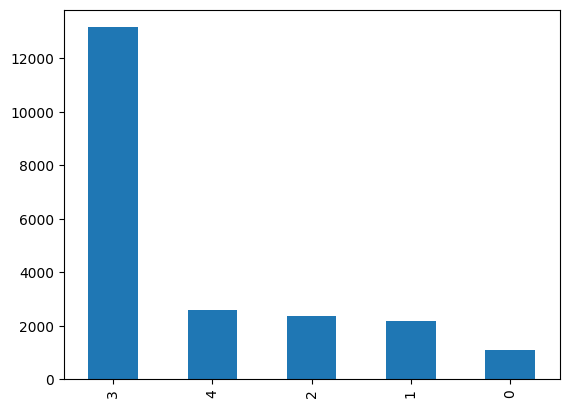

In [35]:
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

index = 3
name = f"run-{index}"
notes = ""

data_path = os.path.join(config.base_input_path, "train.csv")
data_img_dir_path = os.path.join(config.base_input_path, "train_images")
df = pd.read_csv(train_path)

df.label.value_counts().plot(kind="bar")

In [36]:
def set_seed(seed):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONHASHSEED"] = str(seed)
    return random_state

set_seed(42)

RandomState(MT19937) at 0x7F8E594CF040

In [37]:

k_fold = KFold(n_splits=2)
train_dataset = CassavaDataset(
    annotation_path=data_path,
    img_dir_path=data_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),    
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
)
val_dataset = CassavaDataset(
    annotation_path=data_path,
    img_dir_path=data_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
)

for fold, (train_index, val_index) in enumerate(k_fold.split(df)):
    train_subset = Subset(train_dataset, train_index)
    train_dataloader = DataLoader(
        train_subset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        shuffle=True,
    )
    val_subset = Subset(val_dataset, val_index)
    val_dataloader = DataLoader(
        val_subset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
    )
    model = CassavaNetwork()
    model = model.to(torch.device("cuda"))
    model = nn.DataParallel(model)

    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    loss_function = nn.CrossEntropyLoss()

    activate_function = nn.Softmax(dim=1)

    trainer = Trainer(
        model,
        optimizer,
        scheduler,
        loss_function,
        train_dataloader,
    )
    classifier = Classifier(
        model,
        activate_function,
        train_dataloader,
        phase="train",
        phase_input=ClassifierTrainInput(),
    )

    val_classifier = Classifier(
        model,
        activate_function,
        val_dataloader,
        phase="test",
        phase_input=ClassifierTestInput(),
    )


    for epoch in tqdm(range(config.n_epochs)):
        epoch += 1
        train_out = trainer.advance()
        print(f"epoch: {epoch}, train loss: {train_out.loss}")
#         train_infer_out = classifier.infer()
#         print(f"epoch: {epoch}, train acc: {train_infer_out.acc}")
#         val_infer_out = val_classifier.infer()
#         print(f"epoch: {epoch}, val acc: {val_infer_out.acc}")
    break

# Create submissions


/workspace/kaggle-notebooks/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/kaggle-notebooks/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  3%|▎         | 1/30 [00:48<23:39, 48.95s/it]

epoch: 1, train loss: 0.7800209094725904


  7%|▋         | 2/30 [01:38<22:54, 49.08s/it]

epoch: 2, train loss: 0.5410190552827858


 10%|█         | 3/30 [02:27<22:04, 49.07s/it]

epoch: 3, train loss: 0.46544208253423375


 13%|█▎        | 4/30 [03:16<21:15, 49.05s/it]

epoch: 4, train loss: 0.4276925828307867


 17%|█▋        | 5/30 [04:05<20:26, 49.05s/it]

epoch: 5, train loss: 0.3757010849547528


 20%|██        | 6/30 [04:54<19:39, 49.14s/it]

epoch: 6, train loss: 0.36030326455476736


 23%|██▎       | 7/30 [05:44<18:53, 49.27s/it]

epoch: 7, train loss: 0.32665066784691243


 27%|██▋       | 8/30 [06:33<18:07, 49.44s/it]

epoch: 8, train loss: 0.29460111841382014


 30%|███       | 9/30 [07:23<17:16, 49.34s/it]

epoch: 9, train loss: 0.2550673067037548


 33%|███▎      | 10/30 [08:12<16:27, 49.36s/it]

epoch: 10, train loss: 0.2312010574997181


 37%|███▋      | 11/30 [09:01<15:37, 49.32s/it]

epoch: 11, train loss: 0.20154518957826353


 40%|████      | 12/30 [09:51<14:49, 49.39s/it]

epoch: 12, train loss: 0.18002002052075805


 43%|████▎     | 13/30 [10:40<13:58, 49.33s/it]

epoch: 13, train loss: 0.1581495637074113


 47%|████▋     | 14/30 [11:29<13:08, 49.31s/it]

epoch: 14, train loss: 0.13746597427165225


 50%|█████     | 15/30 [12:19<12:20, 49.34s/it]

epoch: 15, train loss: 0.1263820748620977


 53%|█████▎    | 16/30 [13:08<11:30, 49.33s/it]

epoch: 16, train loss: 0.10727489162014708


 57%|█████▋    | 17/30 [13:57<10:41, 49.35s/it]

epoch: 17, train loss: 0.0852217225224844


 60%|██████    | 18/30 [14:47<09:52, 49.34s/it]

epoch: 18, train loss: 0.07621337878074319


 63%|██████▎   | 19/30 [15:36<09:02, 49.28s/it]

epoch: 19, train loss: 0.057702649916921346


 67%|██████▋   | 20/30 [16:25<08:14, 49.40s/it]

epoch: 20, train loss: 0.06194286818416523


 70%|███████   | 21/30 [17:15<07:24, 49.37s/it]

epoch: 21, train loss: 0.052262366228249105


 73%|███████▎  | 22/30 [18:04<06:34, 49.37s/it]

epoch: 22, train loss: 0.0496091726790404


 77%|███████▋  | 23/30 [18:53<05:45, 49.30s/it]

epoch: 23, train loss: 0.037198093647713815


 80%|████████  | 24/30 [19:42<04:55, 49.29s/it]

epoch: 24, train loss: 0.03873342468536326


 83%|████████▎ | 25/30 [20:32<04:06, 49.30s/it]

epoch: 25, train loss: 0.03336950531229377


 87%|████████▋ | 26/30 [21:21<03:17, 49.38s/it]

epoch: 26, train loss: 0.03356459615696665


 90%|█████████ | 27/30 [22:11<02:27, 49.32s/it]

epoch: 27, train loss: 0.034684833244509286


 93%|█████████▎| 28/30 [23:00<01:38, 49.31s/it]

epoch: 28, train loss: 0.025204621624046315


 97%|█████████▋| 29/30 [23:49<00:49, 49.33s/it]

epoch: 29, train loss: 0.019526636072744925


100%|██████████| 30/30 [24:39<00:00, 49.30s/it]

epoch: 30, train loss: 0.023019026806910654


## Submission

In [38]:
test_data_img_dir_path = os.path.join(config.base_input_path, "test_images")
test_dataset = CassavaDataset(
    annotation_path=None,
    img_dir_path=test_data_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
)

test_classifier = Classifier(
    model,
    activate_function,
    test_dataloader,
    phase="test",
    phase_input=ClassifierTrainInput(),
)

out = test_classifier.infer(calc_acc=False)
out.df.to_csv("submission.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]


UnboundLocalError: Caught UnboundLocalError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/workspace/kaggle-notebooks/venv/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/workspace/kaggle-notebooks/venv/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/workspace/kaggle-notebooks/venv/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_493828/862654219.py", line 28, in __getitem__
    label = torch.nn.functional.one_hot(torch.tensor([label]), num_classes=5)
UnboundLocalError: local variable 'label' referenced before assignment
